In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.datasets import fetch_covtype 
from sklearn.model_selection import KFold

データのダウンロード：データはsklearnからダウンロード。ラベルは1-7でラベル付けされている。扱いづらそうなのでy=y-1でラベルを0から6にしておく（確かxgboostはラベルが0始まりじゃないと対応してなかった気がしなくもない）

In [2]:
X,y = fetch_covtype(return_X_y=True,as_frame=True)
y=y-1

分割はKFoldで行う。train_test_splitでもできると思うが既存のものを使うこととする。（後で考えたけど重複してサンプリングしてしまうことを考えるとtrain_test_splitは適さない）

In [3]:
kf = KFold(n_splits=5,shuffle=True,random_state=None)

利用するモデルはランダムフォレスト、xgboost、ロジスティック回帰。ランダムフォレストとxgboostはバギング<>ブースティングで特徴量の相関関係について概観することができる。二つのモデルで高い精度が出て、ロジスティック回帰でも高い精度が出る場合ラベルと特徴量には明らかな線形関係がある→corrを使うとものすごい相関係数が出そう。
いずれにしてもデータセットについて見やすくなると思った。

In [4]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [11]:
model = RandomForestClassifier()

In [12]:
score_sum_Random=0
for train_index,eval_index in kf.split(X):
  train_x = X.iloc[train_index]
  train_y = y.iloc[train_index]
  valid_x = X.iloc[eval_index]
  valid_y = y.iloc[eval_index]
  model.fit(train_x,train_y)
  pred = model.predict(valid_x)
  score = accuracy_score(pred,valid_y)
  print("acc is {}".format(score))
  score_sum_Random += score
print("mean score is {}".format(score_sum_Random/5))
importance_random = model.feature_importances_

acc is 0.9544245845632212
acc is 0.954786021014948
acc is 0.9556117794874442
acc is 0.9544500094662742
acc is 0.9549147174747422
mean score is 0.9548374224013261


特徴量の重要度をグラフとして見てみる

In [ ]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)

ax.bar(X.columns[:5],importance_random[:5])

ax.set_xlabel('feature')
ax.set_ylabel('importance')

plt.show()

In [5]:
params = {
    'objective':'multi:softmax',
    'num_class':7,
    'eval_metric':'mlogloss'
}

In [6]:
score_sum_xgb=0
for train_index,eval_index in kf.split(X):
  train_x = X.iloc[train_index]
  train_y = y.iloc[train_index]
  valid_x = X.iloc[eval_index]
  valid_y = y.iloc[eval_index]
  xgb_train = xgb.DMatrix(train_x,label=train_y)
  xgb_test = xgb.DMatrix(valid_x,label=valid_y)
  model = xgb.XGBClassifier(params)
  model.fit(train_x,train_y)
  pred = model.predict_proba(valid_x)
  score = accuracy_score(np.argmax(pred,axis=1),valid_y)
  print("acc is {}".format(score))
  score_sum_xgb += score
print("mean score is {}".format(score_sum_xgb/5))
importance_xgb = model.feature_importances_

/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


acc is 0.8718535666032718


/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


acc is 0.868867413061625


/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


acc is 0.872644188568183


/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


acc is 0.867833600110153


/usr/local/lib/python3.9/dist-packages/xgboost/core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


acc is 0.8693395982857438
mean score is 0.8701076733257953


同様に特徴量の重要度を見てみる

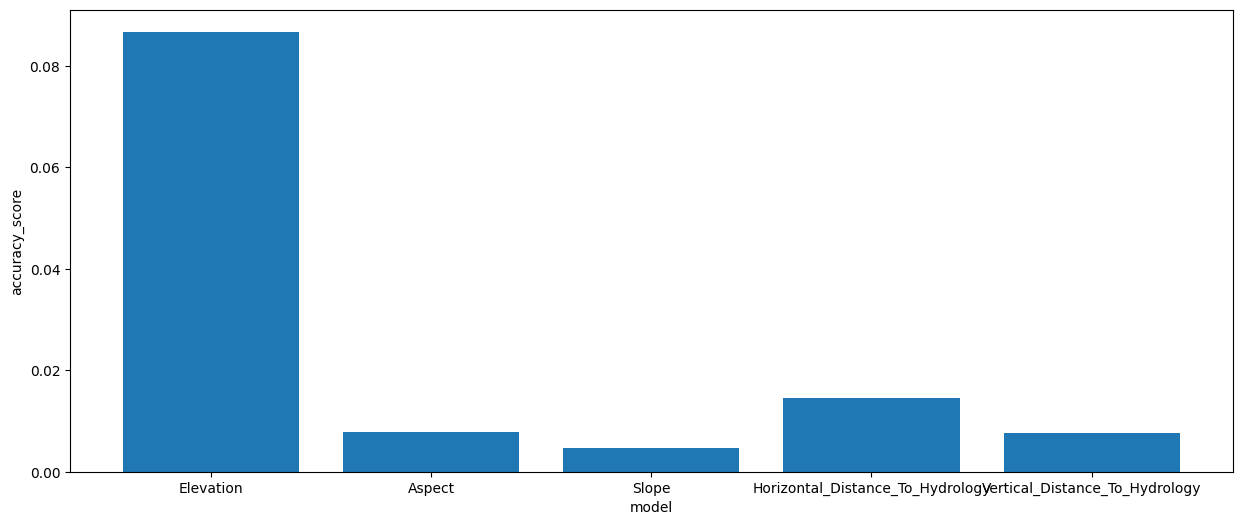

In [10]:
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)

ax.bar(X.columns[:5],importance_xgb[:5])

ax.set_xlabel('feature')
ax.set_ylabel('importance')

plt.show()

In [17]:
model = LogisticRegression()

In [ ]:
score_sum_Logic=0
for train_index,eval_index in kf.split(X):
  train_x = X.iloc[train_index]
  train_y = y.iloc[train_index]
  valid_x = X.iloc[eval_index]
  valid_y = y.iloc[eval_index]
  model.fit(train_x,train_y)
  pred = model.predict(valid_x)
  score = accuracy_score(pred,valid_y)
  print("acc is {}".format(score))
  score_sum_Logic += score
print("mean score is {}".format(score_sum_Logic/5))

In [ ]:
score_list = np.array([score_sum_Random/5,score_sum_xgb/5,score_sum_Logic/5])
import matplotlib.pyplot as plt
label_list = ['RandomForest','xgboost','Logisticregression']
fig = plt.figure(figsize=(15,6))

ax = fig.add_subplot(111)

ax.bar(label_list,score_list)

ax.set_xlabel('model')
ax.set_ylabel('accuracy_score')

plt.show()

↑やはりロジスティック回帰ではあまり高い精度が出る訳ではない→ラベルとものすごい相関のある特徴量はないと考えられる。

データセットの概要を見つめる

In [ ]:
import seaborn as sns
corr = X[["Elevation","Aspect","Slope","Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology","Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon","Hillshade_3pm","Horizontal_Distance_To_Fire_Points"]].corr()
plt.subplots(figsize=(12,10))
sns.heatmap(corr)
plt.xticks(size=13)
plt.yticks(size=13)
plt.show()

In [ ]:
df = pd.concat([X,y],axis = 1)
df

In [ ]:
df = pd.concat([X,y],axis = 1)
list_data_corr = [['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology'],
                  ['Elevation','Horizontal_Distance_To_Roadways'],
                  ['Aspect','Hillshade_3pm'],
                  ['Hillshade_3pm','Hillshade_Noon']]

for i,j in list_data_corr:
    plt.subplots(figsize=(10,8))
    sns.scatterplot(data=df, x=i, y=j, hue="Cover_Type", legend='full', palette='rainbow_r',alpha = 0.4)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel(i, size=16)
    plt.ylabel(j, size=16)
    
    plt.show()

In [9]:
X["New_feature"] = ((50<X["Hillshade_3pm"])&(X["Hillshade_3pm"]<250) & (150<X["Hillshade_Noon"])&(X["Hillshade_Noon"]<250)).astype(int)

In [ ]:
X["New_feature"].head()

追加した特徴量での学習、精度の確認

In [ ]:
score_sum_xgb=0
for train_index,eval_index in kf.split(X):
  train_x = X.iloc[train_index]
  train_y = y.iloc[train_index]
  valid_x = X.iloc[eval_index]
  valid_y = y.iloc[eval_index]
  xgb_train = xgb.DMatrix(train_x,label=train_y)
  xgb_test = xgb.DMatrix(valid_x,label=valid_y)
  model = xgb.train(params,xgb_train)
  pred = model.predict(xgb_test)
  score = accuracy_score(pred,valid_y)
  print("acc is {}".format(score))
  score_sum_xgb += score
print("mean score is {}".format(score_sum_xgb/5))